# EDA — Part 2: Exposure Density & Sparsity

Examines exposure density and sparsity patterns across H3 cells


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import h3
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap


In [2]:
DATA_PATH = Path('../../dataset/Capstone2025_nsi_lvl9_with_landcover_and_color.csv.gz')
FIGURES_DIR = Path('../../figures/eda')
TABLES_DIR = Path('../../results/tables')

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH, compression='gzip', low_memory=False)
print(f"Dataset shape: {df.shape}")

Dataset shape: (2417766, 8)


### Compute Total Exposure per H3 Cell


In [3]:
exposure_per_h3 = df.groupby('h3').size().reset_index(name='total_exposure')
exposure_per_h3 = exposure_per_h3.sort_values('total_exposure', ascending=False)

print("Exposure per H3 cell summary:")
print(exposure_per_h3['total_exposure'].describe())
print(f"\nMin: {exposure_per_h3['total_exposure'].min()}")
print(f"Max: {exposure_per_h3['total_exposure'].max()}")
print(f"Median: {exposure_per_h3['total_exposure'].median():.1f}")
print(f"Mean: {exposure_per_h3['total_exposure'].mean():.1f}")

display(exposure_per_h3.head(10))


Exposure per H3 cell summary:
count    221108.000000
mean         10.934774
std           7.713547
min           1.000000
25%           3.000000
50%          12.000000
75%          16.000000
max          71.000000
Name: total_exposure, dtype: float64

Min: 1
Max: 71
Median: 12.0
Mean: 10.9


,h3,total_exposure
23568,89283082b53ffff,71
153952,8929a1d75afffff,70
23024,8928308108bffff,69
153927,8929a1d7533ffff,69
23523,89283082a23ffff,68
23041,892830810d7ffff,68
153176,8929a1d62dbffff,67
23432,89283082843ffff,64
153955,8929a1d75bbffff,64
153951,8929a1d75abffff,64


### Examine the Distribution of Exposure (Global)


In [4]:
median_exposure = exposure_per_h3['total_exposure'].median()
pct_below_5 = (exposure_per_h3['total_exposure'] < 5).mean() * 100
pct_below_10 = (exposure_per_h3['total_exposure'] < 10).mean() * 100
pct_below_20 = (exposure_per_h3['total_exposure'] < 20).mean() * 100

print(f"Median exposure: {median_exposure:.1f}")
print(f"% of H3 cells with <5 structures: {pct_below_5:.1f}%")
print(f"% of H3 cells with <10 structures: {pct_below_10:.1f}%")
print(f"% of H3 cells with <20 structures: {pct_below_20:.1f}%")


Median exposure: 12.0
% of H3 cells with <5 structures: 30.5%
% of H3 cells with <10 structures: 44.0%
% of H3 cells with <20 structures: 92.0%


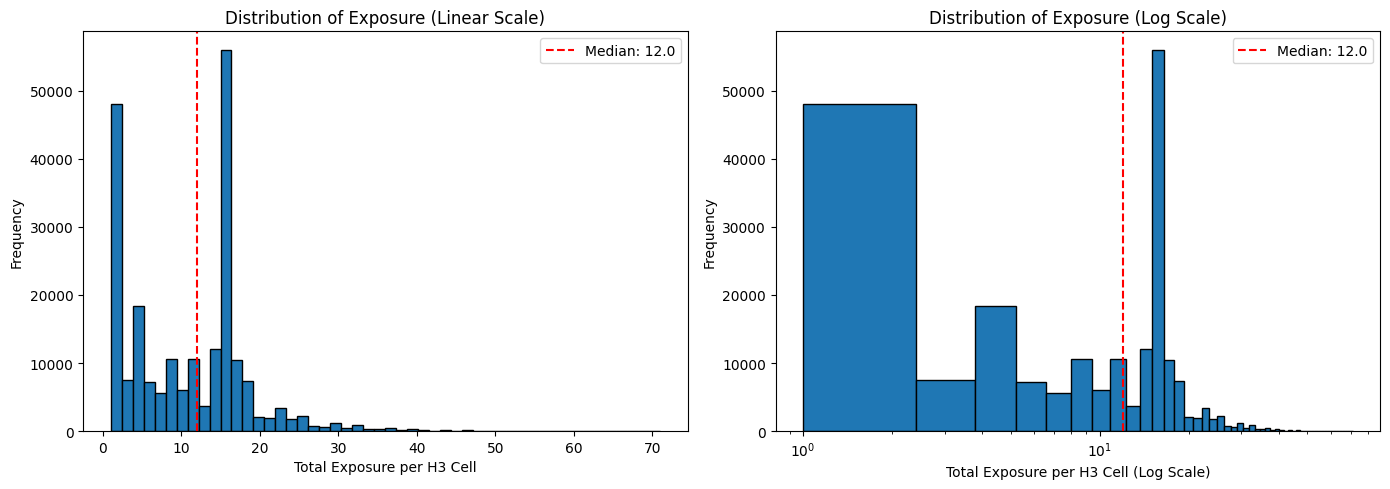

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(exposure_per_h3['total_exposure'], bins=50, edgecolor='black')
axes[0].set_xlabel('Total Exposure per H3 Cell')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exposure (Linear Scale)')
axes[0].axvline(median_exposure, color='red', linestyle='--', label=f'Median: {median_exposure:.1f}')
axes[0].legend()

# Create log-spaced bins for proper log-scale histogram
min_exposure = exposure_per_h3['total_exposure'].min()
max_exposure = exposure_per_h3['total_exposure'].max()
log_bins = np.logspace(np.log10(min_exposure), np.log10(max_exposure), num=51)

axes[1].hist(exposure_per_h3['total_exposure'], bins=log_bins, edgecolor='black')
axes[1].set_xscale('log')
axes[1].set_xlabel('Total Exposure per H3 Cell (Log Scale)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Exposure (Log Scale)')
axes[1].axvline(median_exposure, color='red', linestyle='--', label=f'Median: {median_exposure:.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


### Exposure by Landcover Class


In [6]:
h3_landcover_exposure = df.groupby(['h3', 'lc_type']).size().reset_index(name='exposure')
landcover_stats = h3_landcover_exposure.groupby('lc_type')['exposure'].agg([
    'median', 'mean', 'std', 'min', 'max'
]).reset_index()
landcover_stats.columns = ['landcover', 'median_exposure', 'mean_exposure', 'std_exposure', 'min_exposure', 'max_exposure']

landcover_stats['iqr'] = h3_landcover_exposure.groupby('lc_type')['exposure'].apply(
    lambda x: x.quantile(0.75) - x.quantile(0.25)
).values

landcover_stats['pct_low_exposure'] = h3_landcover_exposure.groupby('lc_type')['exposure'].apply(
    lambda x: (x < 10).mean() * 100
).values

landcover_stats = landcover_stats.sort_values('median_exposure', ascending=False)

print("Exposure statistics by landcover class:")
display(landcover_stats)


Exposure statistics by landcover class:


,landcover,median_exposure,mean_exposure,std_exposure,min_exposure,max_exposure,iqr,pct_low_exposure
6,urban,16.0,16.601282,7.056625,1,71,2.0,12.129360
8,urban+crop,16.0,12.259709,6.915828,1,54,10.0,33.480249
10,urban+grass,16.0,14.211894,6.171086,1,53,3.0,19.659725
7,urban+barren,15.0,12.920835,6.899969,1,63,8.0,29.436982
9,urban+forest,13.0,11.744150,5.956771,1,46,9.0,32.006895
12,urban+shrub,13.0,10.738078,6.553090,1,54,11.0,42.348754
11,urban+other,8.0,9.588235,4.861312,3,16,9.0,52.941176
2,forest,4.0,4.965652,3.935015,1,39,5.0,81.887679
3,grass,4.0,5.345036,4.016566,1,29,5.0,84.037301
0,barren,2.0,3.984162,4.203739,1,46,4.0,89.513927


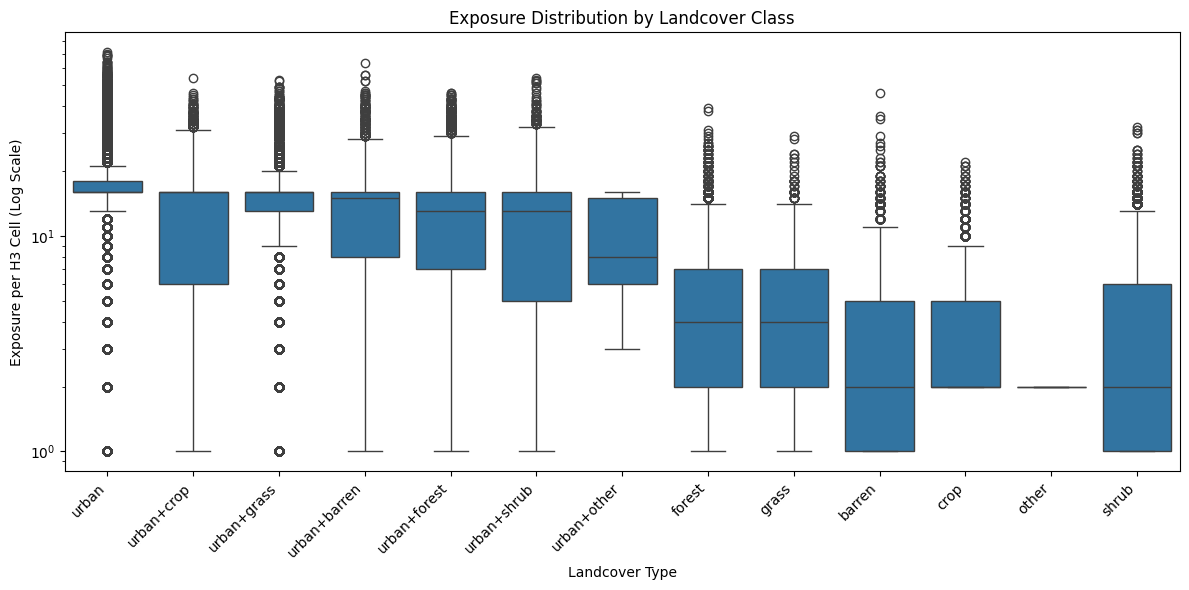

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
landcover_order = landcover_stats.sort_values('median_exposure', ascending=False)['landcover'].values
sns.boxplot(data=h3_landcover_exposure, x='lc_type', y='exposure', order=landcover_order, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Landcover Type')
ax.set_ylabel('Exposure per H3 Cell (Log Scale)')
ax.set_title('Exposure Distribution by Landcover Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_by_landcover.png', dpi=150, bbox_inches='tight')
plt.show()


### Exposure by County


In [8]:
county_stats = df.groupby('fips').agg({
    'h3': 'nunique',
    'clr': 'count'
}).reset_index()
county_stats.columns = ['county_fips', 'n_h3_cells', 'total_exposure']

h3_county_exposure = df.groupby(['h3', 'fips']).size().reset_index(name='exposure')
county_medians = h3_county_exposure.groupby('fips')['exposure'].median().reset_index()
county_medians.columns = ['county_fips', 'median_exposure']

county_stats = county_stats.merge(county_medians, on='county_fips')
county_stats = county_stats.sort_values('median_exposure', ascending=False)

print("Exposure statistics by county:")
display(county_stats.head(20))


Exposure statistics by county:


,county_fips,n_h3_cells,total_exposure,median_exposure
37,6075,948,22197,19.0
0,6001,5443,81348,16.0
18,6037,28581,445121,16.0
55,6111,4363,54531,16.0
47,6095,2489,29649,16.0
42,6085,7045,97263,16.0
33,6067,7780,100800,16.0
29,6059,10161,157035,16.0
6,6013,5949,73046,14.0
56,6113,1146,12939,14.0


In [9]:
h3_exposure_map = exposure_per_h3.copy()
h3_exposure_map['log_exposure'] = np.log1p(h3_exposure_map['total_exposure'])

print("Spatial density summary:")
print(f"Exposure ranges from {h3_exposure_map['total_exposure'].min()} to {h3_exposure_map['total_exposure'].max()}")
print(f"Log exposure ranges from {h3_exposure_map['log_exposure'].min():.2f} to {h3_exposure_map['log_exposure'].max():.2f}")
print("\nNote: For full spatial visualization, H3 cells can be mapped using their coordinates.")
print("The exposure distribution shows clear urban-rural contrast patterns.")


Spatial density summary:
Exposure ranges from 1 to 71
Log exposure ranges from 0.69 to 4.28

Note: For full spatial visualization, H3 cells can be mapped using their coordinates.
The exposure distribution shows clear urban-rural contrast patterns.


### Exposure vs Category Diversity


In [10]:
h3_diversity = df.groupby('h3').agg({
    'clr': 'nunique',
    'st_damcat': 'nunique',
    'bldgtype': 'nunique'
}).reset_index()
h3_diversity.columns = ['h3', 'n_colors', 'n_occupancy', 'n_bldgtype']

h3_diversity = h3_diversity.merge(exposure_per_h3, on='h3')

print("Exposure vs category diversity:")
print(f"Correlation (exposure vs n_colors): {h3_diversity['total_exposure'].corr(h3_diversity['n_colors']):.3f}")
print(f"Correlation (exposure vs n_occupancy): {h3_diversity['total_exposure'].corr(h3_diversity['n_occupancy']):.3f}")
print(f"Correlation (exposure vs n_bldgtype): {h3_diversity['total_exposure'].corr(h3_diversity['n_bldgtype']):.3f}")


Exposure vs category diversity:
Correlation (exposure vs n_colors): 0.925
Correlation (exposure vs n_occupancy): 0.465
Correlation (exposure vs n_bldgtype): 0.780


#### County-Level Exposure Map


C:\Users\sardo\AppData\Local\Temp\ipykernel_420\1285064057.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Reds")


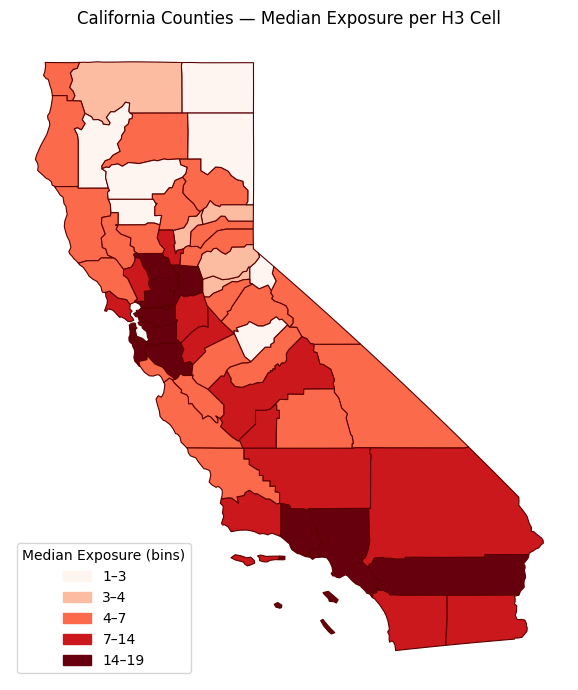

In [ ]:
df_county = county_stats.copy()
df_county['county_fips'] = df_county['county_fips'].astype(int).astype(str).str.zfill(5)

counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip")
counties_ca = counties[counties["STATEFP"] == "06"].copy()
counties_ca["county_fips"] = counties_ca["GEOID"]

gdf_county = counties_ca.merge(df_county, on="county_fips", how="left")

breaks = [1.0, 3.0, 4.0, 7.0, 14.0, 19.0]
labels = ["1–3", "3–4", "4–7", "7–14", "14–19"]

fig, ax = plt.subplots(figsize=(7, 7))
cmap = get_cmap("Reds")
norm = BoundaryNorm(breaks, ncolors=cmap.N, clip=True)

gdf_county.plot(
    column="median_exposure",
    cmap=cmap,
    norm=norm,
    linewidth=0.8,
    edgecolor="#5a0000",
    ax=ax,
    missing_kwds={"color": "#f0f0f0", "label": "No data"},
)

ax.set_axis_off()
ax.set_title("California Counties — Median Exposure per H3 Cell", fontsize=12)

patches = []
for i, lab in enumerate(labels):
    lo, hi = breaks[i], breaks[i+1]
    sample = (lo + hi) / 2
    patches.append(mpatches.Patch(color=cmap(norm(sample)), label=lab))

ax.legend(
    handles=patches,
    title="Median Exposure (bins)",
    loc="lower left",
    frameon=True
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_by_county_map.png', dpi=150, bbox_inches='tight')
plt.show()


#### Total Exposure by County


C:\Users\sardo\AppData\Local\Temp\ipykernel_420\1777205374.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_total = get_cmap("Oranges")


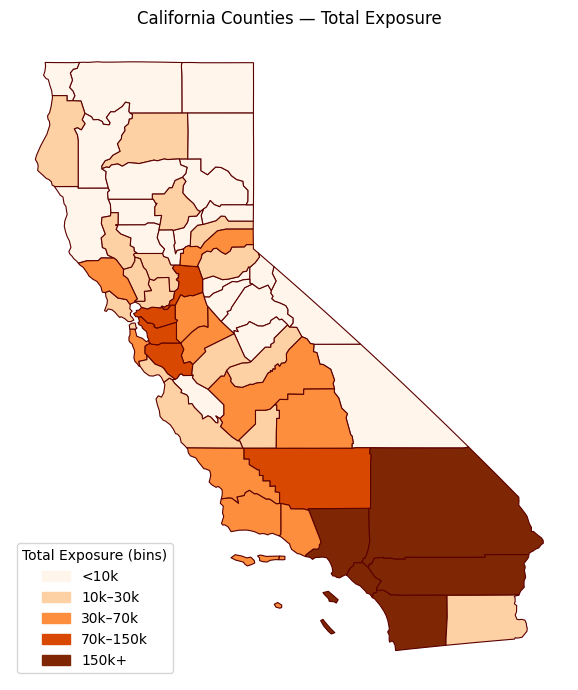

In [12]:
counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip")
counties_ca = counties[counties["STATEFP"] == "06"].copy()
counties_ca["county_fips"] = counties_ca["GEOID"]

df_county_total = county_stats.copy()
df_county_total['county_fips'] = df_county_total['county_fips'].astype(int).astype(str).str.zfill(5)

gdf_county_total = counties_ca.merge(df_county_total, on="county_fips", how="left")

breaks_total = [0, 10000, 30000, 70000, 150000, 450000]
labels_total = ["<10k", "10k–30k", "30k–70k", "70k–150k", "150k+"]

fig, ax = plt.subplots(figsize=(7, 7))
cmap_total = get_cmap("Oranges")
norm_total = BoundaryNorm(breaks_total, ncolors=cmap_total.N, clip=True)

gdf_county_total.plot(
    column="total_exposure",
    cmap=cmap_total,
    norm=norm_total,
    linewidth=0.8,
    edgecolor="#5a0000",
    ax=ax,
    missing_kwds={"color": "#f0f0f0", "label": "No data"},
)

ax.set_axis_off()
ax.set_title("California Counties — Total Exposure", fontsize=12)

patches_total = []
for i, lab in enumerate(labels_total):
    lo, hi = breaks_total[i], breaks_total[i+1]
    sample = (lo + hi) / 2
    patches_total.append(mpatches.Patch(color=cmap_total(norm_total(sample)), label=lab))

ax.legend(
    handles=patches_total,
    title="Total Exposure (bins)",
    loc="lower left",
    frameon=True
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_total_exposure_by_county_map.png', dpi=150, bbox_inches='tight')
plt.show()


#### Average Category Diversity by County


C:\Users\sardo\AppData\Local\Temp\ipykernel_420\1448720429.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_div = get_cmap("Purples")


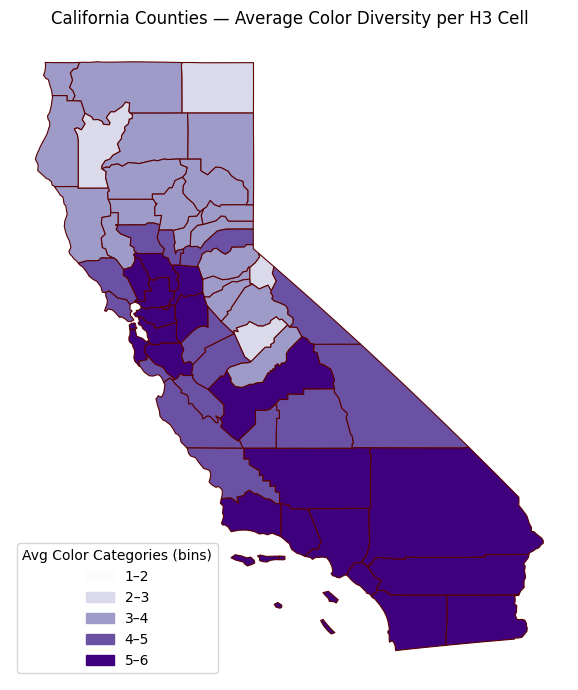

In [13]:
h3_county = df[['h3', 'fips']].drop_duplicates()
h3_diversity_county = h3_diversity.merge(h3_county, on='h3', how='left')
county_diversity = h3_diversity_county.groupby('fips').agg({
    'n_colors': 'mean',
    'n_occupancy': 'mean',
    'n_bldgtype': 'mean'
}).reset_index()
county_diversity.columns = ['county_fips', 'avg_n_colors', 'avg_n_occupancy', 'avg_n_bldgtype']

counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip")
counties_ca = counties[counties["STATEFP"] == "06"].copy()
counties_ca["county_fips"] = counties_ca["GEOID"]

df_county_div = county_diversity.copy()
df_county_div['county_fips'] = df_county_div['county_fips'].astype(int).astype(str).str.zfill(5)

gdf_county_div = counties_ca.merge(df_county_div, on="county_fips", how="left")

breaks_div = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
labels_div = ["1–2", "2–3", "3–4", "4–5", "5–6"]

fig, ax = plt.subplots(figsize=(7, 7))
cmap_div = get_cmap("Purples")
norm_div = BoundaryNorm(breaks_div, ncolors=cmap_div.N, clip=True)

gdf_county_div.plot(
    column="avg_n_colors",
    cmap=cmap_div,
    norm=norm_div,
    linewidth=0.8,
    edgecolor="#5a0000",
    ax=ax,
    missing_kwds={"color": "#f0f0f0", "label": "No data"},
)

ax.set_axis_off()
ax.set_title("California Counties — Average Color Diversity per H3 Cell", fontsize=12)

patches_div = []
for i, lab in enumerate(labels_div):
    lo, hi = breaks_div[i], breaks_div[i+1]
    sample = (lo + hi) / 2
    patches_div.append(mpatches.Patch(color=cmap_div(norm_div(sample)), label=lab))

ax.legend(
    handles=patches_div,
    title="Avg Color Categories (bins)",
    loc="lower left",
    frameon=True
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_diversity_by_county_map.png', dpi=150, bbox_inches='tight')
plt.show()


#### Sparsity Pattern by County


C:\Users\sardo\AppData\Local\Temp\ipykernel_420\2504986739.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_sparse = get_cmap("Blues")


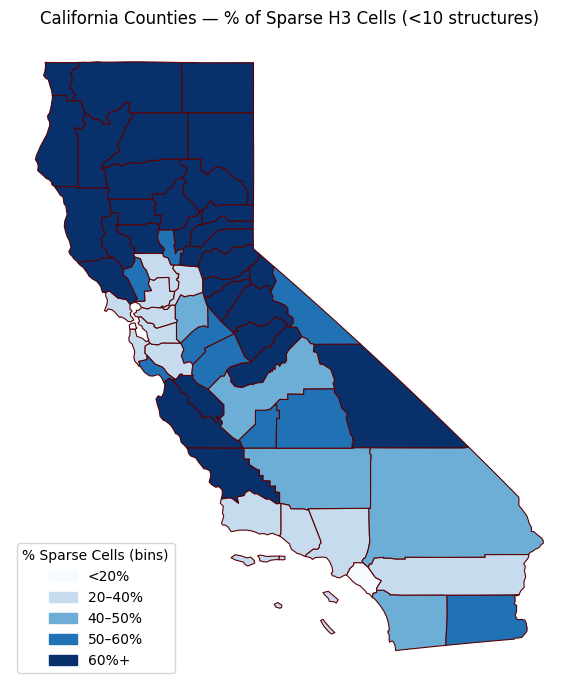

In [14]:
exposure_per_h3_county = exposure_per_h3.merge(h3_county, on='h3', how='left')
sparse_cells = exposure_per_h3_county[exposure_per_h3_county['total_exposure'] < 10]
county_sparsity = sparse_cells.groupby('fips').size().reset_index(name='n_sparse_cells')
county_total_cells = exposure_per_h3_county.groupby('fips').size().reset_index(name='n_total_cells')
county_sparsity = county_sparsity.merge(county_total_cells, on='fips', how='right').fillna(0)
county_sparsity['pct_sparse'] = (county_sparsity['n_sparse_cells'] / county_sparsity['n_total_cells'] * 100).round(1)
county_sparsity.columns = ['county_fips', 'n_sparse_cells', 'n_total_cells', 'pct_sparse']

counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip")
counties_ca = counties[counties["STATEFP"] == "06"].copy()
counties_ca["county_fips"] = counties_ca["GEOID"]

df_county_sparse = county_sparsity.copy()
df_county_sparse['county_fips'] = df_county_sparse['county_fips'].astype(int).astype(str).str.zfill(5)

gdf_county_sparse = counties_ca.merge(df_county_sparse, on="county_fips", how="left")

breaks_sparse = [0, 20, 40, 50, 60, 85]
labels_sparse = ["<20%", "20–40%", "40–50%", "50–60%", "60%+"]

fig, ax = plt.subplots(figsize=(7, 7))
cmap_sparse = get_cmap("Blues")
norm_sparse = BoundaryNorm(breaks_sparse, ncolors=cmap_sparse.N, clip=True)

gdf_county_sparse.plot(
    column="pct_sparse",
    cmap=cmap_sparse,
    norm=norm_sparse,
    linewidth=0.8,
    edgecolor="#5a0000",
    ax=ax,
    missing_kwds={"color": "#f0f0f0", "label": "No data"},
)

ax.set_axis_off()
ax.set_title("California Counties — % of Sparse H3 Cells (<10 structures)", fontsize=12)

patches_sparse = []
for i, lab in enumerate(labels_sparse):
    lo, hi = breaks_sparse[i], breaks_sparse[i+1]
    sample = (lo + hi) / 2
    patches_sparse.append(mpatches.Patch(color=cmap_sparse(norm_sparse(sample)), label=lab))

ax.legend(
    handles=patches_sparse,
    title="% Sparse Cells (bins)",
    loc="lower left",
    frameon=True
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_sparsity_by_county_map.png', dpi=150, bbox_inches='tight')
plt.show()


In [16]:
def categorize_exposure(exposure):
    if exposure < 5:
        return 'Very Low (<5)'
    elif exposure < 10:
        return 'Low (5-9)'
    elif exposure < 20:
        return 'Moderate (10-19)'
    elif exposure < 50:
        return 'Medium (20-49)'
    else:
        return 'High (50+)'

exposure_per_h3['exposure_bin'] = exposure_per_h3['total_exposure'].apply(categorize_exposure)

sparsity_regimes = exposure_per_h3.groupby('exposure_bin').agg({
    'h3': 'count',
    'total_exposure': 'sum'
}).reset_index()
sparsity_regimes.columns = ['exposure_bin', 'n_h3_cells', 'total_structures']

sparsity_regimes['pct_h3_cells'] = (sparsity_regimes['n_h3_cells'] / len(exposure_per_h3) * 100).round(2)
sparsity_regimes['pct_structures'] = (sparsity_regimes['total_structures'] / exposure_per_h3['total_exposure'].sum() * 100).round(2)

bin_order = ['Very Low (<5)', 'Low (5-9)', 'Moderate (10-19)', 'Medium (20-49)', 'High (50+)']
sparsity_regimes['exposure_bin'] = pd.Categorical(sparsity_regimes['exposure_bin'], categories=bin_order, ordered=True)
sparsity_regimes = sparsity_regimes.sort_values('exposure_bin')

print("Sparsity regime analysis:")
display(sparsity_regimes)


Sparsity regime analysis:


,exposure_bin,n_h3_cells,total_structures,pct_h3_cells,pct_structures
4,Very Low (<5),67338,142864,30.45,5.91
1,Low (5-9),29878,203742,13.51,8.43
3,Moderate (10-19),106118,1602487,47.99,66.28
2,Medium (20-49),17650,461846,7.98,19.10
0,High (50+),124,6827,0.06,0.28


In [17]:
exposure_per_h3.to_csv(TABLES_DIR / 'eda_exposure_per_h3.csv', index=False)
landcover_stats.to_csv(TABLES_DIR / 'eda_exposure_by_landcover.csv', index=False)
county_stats.to_csv(TABLES_DIR / 'eda_exposure_by_county.csv', index=False)
sparsity_regimes.to_csv(TABLES_DIR / 'eda_sparsity_regimes.csv', index=False)
h3_diversity.to_csv(TABLES_DIR / 'eda_exposure_diversity.csv', index=False)
